In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Datos de prueba con las señales hechas con los modelos entrenados 

In [2]:
data_5m = pd.read_csv('data/indicadores_test_5m.csv')
data_5m

,Timestamp,Close,xg_boost_buy,reg_log_buy,SVC_buy,xg_boost_sell,reg_log_sell,SVC_sell
0,1672764300,124.849998,True,False,True,False,True,True
1,1672764600,124.599899,True,False,True,False,True,True
2,1672764900,124.742500,True,False,True,False,True,True
3,1672765200,124.730003,True,False,True,False,True,True
4,1672765500,124.930000,True,False,True,False,True,True
...,...,...,...,...,...,...,...,...
19637,1703882400,192.500000,True,False,True,True,True,True
19638,1703882700,192.510299,True,False,True,True,True,True
19639,1703883000,192.369995,True,False,True,True,True,True
19640,1703883300,192.520004,True,False,True,True,True,True


## Estrategia de 5 minutos con hiperparametros optimizados 

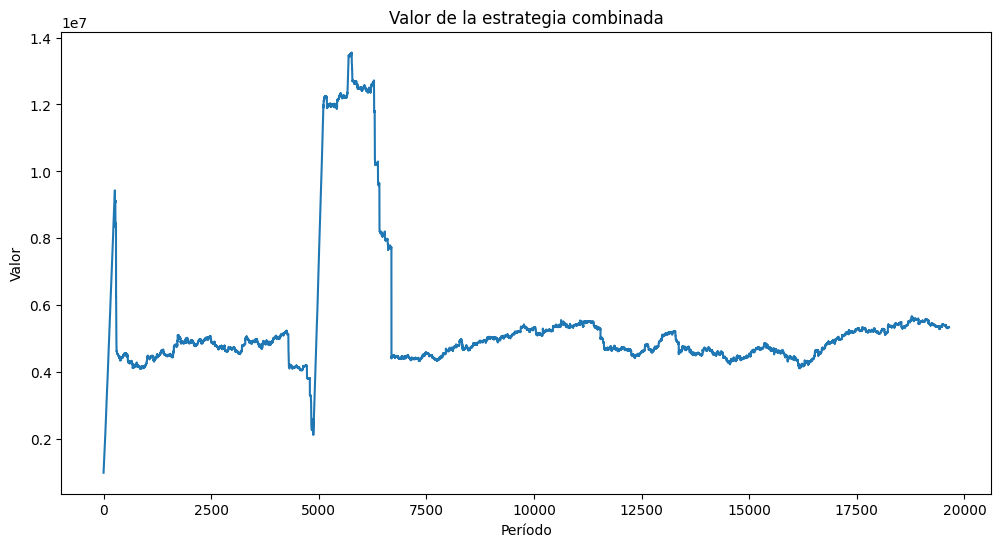

Valor de la estrategia:  5347516.068737768


In [18]:

# Parámetros óptimos
stop_loss_long = 0.03577213912558565
take_profit_long = 0.28986074807515007
stop_loss_short = 0.033097932500542
take_profit_short = 0.045259371081757024
n_shares_long = 57
n_shares_short = 99

# Variables de la estrategia
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares,
                 stop_loss,take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at =  None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Ejecutar la estrategia
for i, row in data_5m.iterrows():
    # Cerrar operaciones activas
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:  # Cerrar operaciones perdedoras
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:  # Cerrar operaciones con ganancias
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:  # Cerrar operaciones perdedoras
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:  # Cerrar operaciones con ganancias
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations


    if cash >= row['Close'] * n_shares_long * (1 + com):
                if row['xg_boost_buy']:
                    active_operations.append(Operation(operation_type='Long',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares= n_shares_long,
                                                            stop_loss=(row['Close'] * stop_loss_long),
                                                            take_profit=row['Close'] * (1 + take_profit_long)))
                    cash += row['Close'] * n_shares_long * (1 + com)

    if cash >= row['Close'] * n_shares_short * (1 + com):

                if row['xg_boost_sell']:
                    active_operations.append(Operation(operation_type='Short',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares=n_shares_short,
                                                            stop_loss=row['Close'] * (1 + stop_loss_short),
                                                            take_profit=row['Close'] * take_profit_short))

                    cash -= row['Close'] * (1- com) * n_shares_short

    # Valor de la estrategia
    total_value = len(active_operations) * row.Close * (n_shares_short + n_shares_long)
    strategy_value.append(cash + total_value)

# Graficar el valor de la estrategia a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia combinada')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()
print("Valor de la estrategia: ", strategy_value[-1])

## Datos de prueba con las señales hechas con los modelos entrenados 

In [19]:
data_1h = pd.read_csv('data/indicadores_test_1h.csv')
data_1h

,Timestamp,Close,xg_boost_buy,reg_log_buy,SVC_buy,xg_boost_sell,reg_log_sell,SVC_sell
0,1610051400,130.860000,False,False,True,True,True,True
1,1610116200,130.380004,False,False,True,True,True,True
2,1610119800,131.070007,False,False,True,True,True,True
3,1610123400,132.154998,False,False,True,True,True,True
4,1610127000,131.115005,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...
5701,1703871000,191.899993,False,False,True,True,True,True
5702,1703874600,192.119995,False,False,True,True,True,True
5703,1703878200,192.679992,False,False,True,True,True,True
5704,1703881800,192.520004,False,False,True,True,True,True


## Estrategia de 1 hora con hiperparametros optimizados 

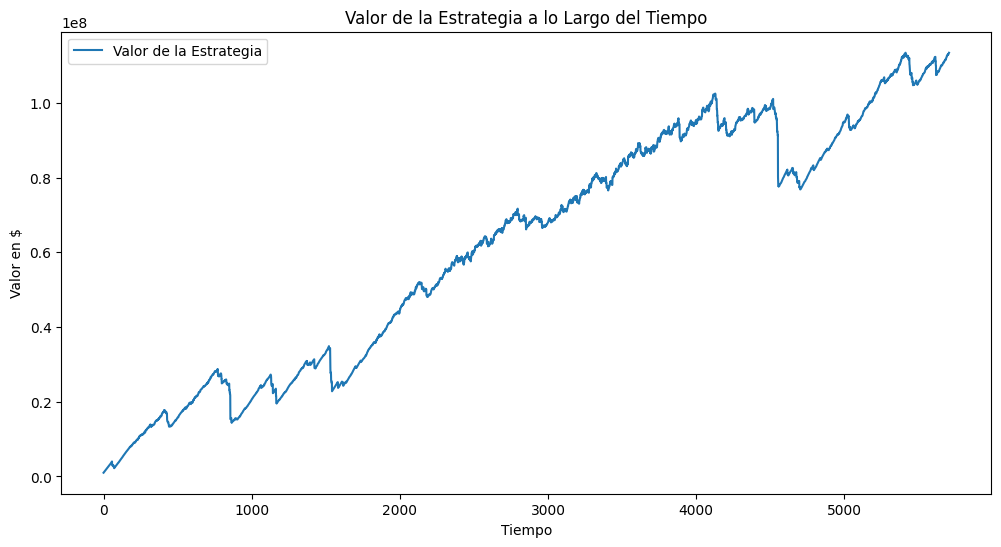

Valor de la estrategia:  113386070.46785651


In [36]:
# Parámetros óptimos
stop_loss_long = 0.043223250201488095
take_profit_long = 0.04998083795768937
stop_loss_short = 0.0486233499852006
take_profit_short = 0.020625620334624544
n_shares_long = 100
n_shares_short = 100

# Variables de la estrategia
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [cash]

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

    def close(self, sold_at):
        self.sold_at = sold_at

# Ejecutar la estrategia
for i, row in data_1h.iterrows():
    # Cerrar operaciones activas
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if row.Close <= op.stop_loss or row.Close >= op.take_profit:
                cash += op.n_shares * row.Close * (1 - com)
                op.close(row.Close)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if row.Close >= op.stop_loss or row.Close <= op.take_profit:
                cash += (op.bought_at - row.Close) * op.n_shares * (1 - com)  # Ajustar por comisión
                op.close(row.Close)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    if cash >= row['Close'] * n_shares_long * (1 + com):
                if row['SVC_buy']:
                    active_operations.append(Operation(operation_type='Long',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares= n_shares_long,
                                                            stop_loss=(row['Close'] * stop_loss_long),
                                                            take_profit=row['Close'] * (1 + take_profit_long)))
                    cash += row['Close'] * n_shares_long * (1 + com)

    if cash >= row['Close'] * n_shares_short * (1 + com):

                if row['reg_log_sell']:
                    active_operations.append(Operation(operation_type='Short',
                                                            bought_at=row['Close'],
                                                            timestamp=row.Timestamp,
                                                            n_shares=n_shares_short,
                                                            stop_loss=row['Close'] * (1 + stop_loss_short),
                                                            take_profit=row['Close'] * take_profit_short))

                    cash -= row['Close'] * (1- com) * n_shares_short

    # Valor de la estrategia
    total_value = len(active_operations) * row.Close * (n_shares_short + n_shares_long)
    strategy_value.append(cash + total_value)

# Graficar el valor de la estrategia a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(strategy_value, label='Valor de la Estrategia')
plt.title('Valor de la Estrategia a lo Largo del Tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Valor en $')
plt.legend()
plt.show()
print("Valor de la estrategia: ", strategy_value[-1])


En nuestro proyecto, hemos implementado y analizado modelos de machine learning avanzados, específicamente Regresión Logística, Support Vector Classification (SVC), y XGBoost, para trascender la tradicional predicción de precios de acciones y enfocarnos en la clasificación de señales de compra y venta basada en diferentes intervalos de tiempo. La cuidadosa selección y ajuste de parámetros para cada modelo han sido fundamentales para optimizar su rendimiento, permitiéndonos anticipar con mayor precisión los rangos de precio de las acciones. Este enfoque estratégico no solo mejora la capacidad de maximizar las ganancias esperadas sino que también introduce una metodología más robusta y eficiente en el trading, destacando la importancia de la precisión y la gestión del riesgo en las operaciones financieras.

La experiencia obtenida a lo largo de este proyecto recalca el potencial y los desafíos de aplicar el machine learning en el ámbito del trading. Aunque los modelos de machine learning ofrecen una ventaja significativa en la interpretación y predicción del mercado, enfrentan limitaciones como la necesidad de acceso a datos de calidad y el riesgo de sobreajuste. Sin embargo, la adaptabilidad y la capacidad de aprendizaje de estos modelos sugieren un camino prometedor hacia la mejora continua de las estrategias de trading, evidenciando que la integración de tecnología avanzada es esencial para el éxito en el competitivo mundo financiero.